In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ADC->PE conversions for XENON1T
to_pe = 1e-3 * np.array([7.05, 0.0, 0.0, 8.09, 4.38, 7.87, 3.58, 7.5, 7.44, 4.82, 7.07, 5.79,  0.0, 5.55, 7.95, 7.02, 6.39, 8.1, 7.15, 7.43, 7.15, 11.4, 3.97, 7.28,  5.41, 7.4, 0.0, 0.0, 7.04, 7.27, 4.22, 16.79, 4.14, 7.04, 0.0, 5.38,  7.39, 7.02, 4.53, 5.17, 7.13, 5.48, 4.6, 7.33, 6.14, 6.52, 7.59,  4.76, 7.56, 7.54, 4.57, 4.6, 7.12, 8.0, 4.7, 8.68, 3.74, 4.97, 10.36,  7.53, 6.02, 12.45, 0.0, 4.49, 4.82, 0.0, 8.13, 7.27, 3.55, 5.65,  4.55, 8.64, 7.97, 0.0, 3.57, 3.69, 5.87, 5.12, 9.8, 0.0, 5.08, 4.09,  3.87, 8.17, 6.73, 9.03, 0.0, 6.93, 0.0, 6.52, 7.39, 0.0, 4.92, 7.48,  5.82, 4.05, 3.9, 5.77, 8.14, 7.62, 7.61, 5.55, 0.0, 7.12, 5.02, 4.57,  4.46, 7.44, 3.57, 7.58, 7.16, 7.33, 7.69, 6.03, 5.87, 9.64, 4.68,  7.88, 0.0, 10.84, 7.0, 3.62, 7.5, 7.45, 7.69, 7.69, 3.49, 3.61, 7.44,  6.38, 0.0, 5.1, 3.72, 5.22, 0.0, 0.0, 4.43, 0.0, 3.87, 0.0, 3.6,  5.35, 8.4, 5.1, 6.45, 5.07, 4.28, 3.5, 0.0, 7.28, 0.0, 4.25, 0.0,  4.72, 6.26, 7.28, 5.34, 7.55, 3.85, 5.54, 7.5, 7.31, 0.0, 7.76, 7.57,  6.66, 7.29, 0.0, 7.59, 3.8, 3.58, 5.21, 4.29, 7.36, 7.76, 4.0, 6.23,  5.86, 0.0, 7.34, 3.58, 3.57, 5.26, 0.0, 7.67, 4.05, 4.3, 4.21, 7.59,  7.59, 0.0, 6.41, 4.86, 3.73, 5.09, 7.59, 7.64, 7.7, 0.0, 5.25, 8.0,  5.32, 7.91, 0.0, 4.41, 11.82, 0.0, 4.51, 7.05, 8.63, 5.12, 4.45,  4.03, 0.0, 0.0, 3.54, 4.18, 9.5, 3.64, 3.67, 7.28, 3.59, 5.03, 3.6,  5.4, 7.18, 3.73, 6.21, 6.47, 3.7, 7.69, 4.58, 7.46, 6.74, 0.0, 3.66,  7.49, 7.55, 3.64, 0.0, 7.34, 4.06, 3.74, 3.97, 0.0, 4.29, 4.96, 3.77,  8.57, 8.57, 8.57, 8.57, 8.57, 8.57, 214.29, 171.43, 171.43, 171.43,  171.43, 171.43])

In [2]:
from strax import *

### Prepare fake data

In [3]:
records = load('test_records_uncomp')
daq_interface.reader_split(records, 'fake_daq_output')

# Processing

The first time you run this will be much slower, since numba has to do a compilation step.

In [4]:
%%time
records = daq_interface.load_from_readers('fake_daq_output')
baseline(records)
integrate(records)

# Data reduction 1: Remove single electron tails
records = exclude_tails(records, to_pe)

hits = find_hits(records)

# Data reduction 2: Remove samples not near hits
cut_outside_hits(records, hits)

peaks = find_peaks(hits, to_pe)
sum_waveform(peaks, records, to_pe)
peaks = split_peaks(peaks, records, to_pe)
compute_widths(peaks)

save('processed_data', peaks)
save('raw_data', records)

CPU times: user 2.84 s, sys: 648 ms, total: 3.49 s
Wall time: 3.57 s


| System | Active cores | Processing time (sec) | Throughput (MB/core/sec) |
|---------------|----------------------------------|-----------------|
| Pax           | 1     | 936  | 0.32 |
| Event builder | 100 | 1 | 3 |
| Strax   | 1      | 2.6  | 115 |
| Strax, no reduction   | 1  | 5.0 | 60 |

Home machine: strax in 1.5 sec, pax in 540 sec

Eb1: strax in 2.6 sec => pax in 

# Examine processed data

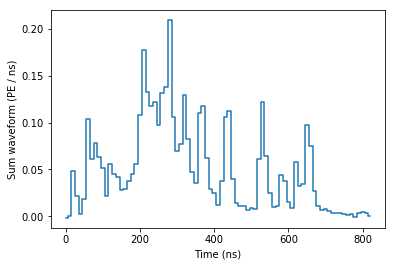

In [5]:
def plot_peak(p, t0=None, **kwargs):
    n = p['length']
    if t0 is None:
        t0 = p['time']
    plt.plot((p['time'] - t0) + np.arange(n) * p['dt'], 
             p['data'][:n] / p['dt'], 
             linestyle='steps-mid',
             **kwargs)
    plt.xlabel("Time (ns)")
    plt.ylabel("Sum waveform (PE / ns)")

plot_peak(peaks[35])

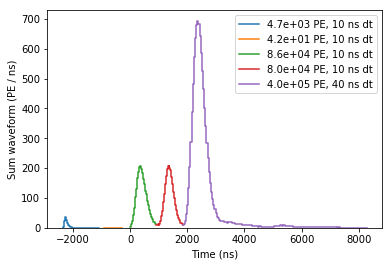

In [6]:
def plot_peaks(main_i, n_before=0, n_after=0):
    for i in main_i + np.arange(-n_before, n_after + 1):
        p = peaks[i]
        plot_peak(p,
                  t0=peaks[main_i]['time'],
                  label='%.1e PE, %d ns dt' % (p['area'], p['dt'], ))
    plt.ylim(0, None)

plot_peaks(30, n_after=2, n_before=2)
plt.legend(loc='upper right')
#plt.yscale('symlog')

In [7]:
area_top = (peaks['area_per_channel'][:,:127] * to_pe[:127].reshape(1, -1)).sum(axis=1)
aft = area_top/peaks['area']
n_channels = (peaks['area_per_channel'] > 0).sum(axis=1)

/home/xedaq/anaconda3/envs/36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(10, 20000.0)

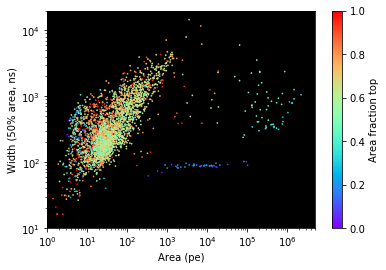

In [8]:
mask = n_channels >= 5

plt.scatter(peaks['area'][mask], 
            peaks['width'][:,5][mask],
            c=aft[mask], 
            s=0.5,
            cmap=plt.cm.rainbow, vmin=0, vmax=1)

plt.colorbar(label='Area fraction top')
plt.xlabel("Area (pe)")
plt.ylabel("Width (50% area, ns)")
plt.gca().patch.set_facecolor('black')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 5e6)
plt.ylim(10, 2e4)